In [1]:
import numpy as np
from math import log, exp, inf, sqrt
from scipy import optimize
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
class Graph:
    def __init__(self, N, K):
        self.N = N
        self.V = list(range(1, N+1))
        
        self.E = []
        self.E_non = []
        
        self.F = np.random.random((N, K))
        
        self.K = K
        self.C = list(range(1, K+1))
        
        self.colors = ['r', 'b', 'g', 'c']
    
    def add_edges_from(self, E):
        self.E = E
        
        for u in self.V:
            for v in self.V[u:]:
                if (u, v) not in E:
                    self.E_non.append([u, v, 0])
    
    def l(self, x):
        x = x.reshape(len(self.V), len(self.C))
        l = 0
        for e in self.E:
            u, v = e[0], e[1]
            try:
                l += log(1 - exp(-np.dot(x[u-1], x[v-1].T)))
            except ValueError:
                l += -1e3
        for e in self.E_non:
            u, v = e[0], e[1]
            l -= np.dot(x[u-1], x[v-1].T)
        return l * (-1)
    
    def detect_communities(self, method='BigCLAM', logging=False):
        result = optimize.minimize(self.l,self.F, method='L-BFGS-B', bounds=[(0, 1)]*(self.N*self.K))
        if logging:
            print(result)
        self.F = result['x'].reshape(len(self.V), len(self.C))
        return self.F
    
    def detect_overlapping_communities(self, method='BigCLAM', logging=False):
        result = optimize.minimize(self.l,self.F, method='L-BFGS-B', bounds=[(0, 1)]*(self.N*self.K))
        if logging:
            print(result)
        self.F = result['x'].reshape(len(self.V), len(self.C))
        e = (2 * self.N) / (len(self.E)*(len(self.E) - 1))
        self.d = sqrt(-log(1-e))
        return self.F, self.F > self.d
    
    def visualize(self, logging=False):
        G = nx.Graph()

        for v in self.V:
            G.add_node(v)
        for e in self.E:
            G.add_edge(e[0], e[1], weight=e[2])

        pos = nx.spring_layout(G)

        for j, c in enumerate(self.C):
            vv = []
            for i, v in enumerate(self.F):
                try:
                    if (self.F > self.d)[i, j]:
                        vv.append(i+1)
                except AttributeError:
                    if np.argmax(v) + 1 == c:
                        vv.append(i+1)
            if log:
                print("Community №" + str(j+1) + ":", "; ".join(list(map(str, vv))))
                
            nx.draw_networkx_nodes(G, pos, nodelist=vv, node_size=700, node_color=self.colors[j])

        nx.draw_networkx_edges(G, pos, width=2)
        nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')

        plt.axis('off')
        plt.show()

Community №1: 1; 2; 3; 4; 5; 6
Community №2: 11; 12; 13; 14; 15
Community №3: 7; 8; 9; 10
Community №4: 16; 17; 18; 19; 20


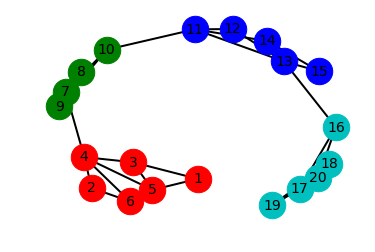

In [5]:
g = Graph(N=20, K=4)
g.add_edges_from([[1, 3, 1], [4, 3, 1], [5, 4, 1], [3, 5, 1], [2, 4, 1], [2, 6, 1], [2, 4, 1], [1, 5, 1], [6, 5, 1], [6, 4, 1],
                  [7, 4, 1], [7, 9, 1], [8, 9, 1], [7, 8, 1], [7, 10, 1], [10, 9, 1], [10, 11, 1],
                  [11, 12, 1], [13, 12, 1], [11, 13, 1], [15, 13, 1], [15, 14, 1], [11, 14, 1], [13, 14, 1],
                  [13, 16, 1], [16, 17, 1], [17, 18, 1], [18, 19, 1], [19, 20, 1], [20, 16, 1], [17, 19, 1]])

g.detect_communities(method='BigCLAM', logging=False)
g.visualize(logging=True)